
Binary matrices (Matrices with elements of 0/1) appear in many applications. A binary matrix can represent relations such as 'User $i$ bought item $j$', or 'Member $i$ likes Member $j$'. Such datasets are often sparse -- only a fraction of the possible entries of a matrix are known. 

A binary matrix can also viewed as the adjacency matrix of a bipartite graph. Hence each entry corresponds to an edge.
One task here is known as link prediction, meaning guessing the presence or absence of edges in the underlying graph. 
This prediction can then be used for several tasks such as recommendation or knowledge-base completion.

In [7]:
# -*- coding: utf-8 -*-

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# Dataset Generation

This cell generates. It sets the elements whom indices sum up to even number to 1.

In [8]:
M = 10 # Use a square matrix of 50x50. You can change it if you wish
original_matrix = np.array([[float((i + j) % 2 == 0) for j in range(M)] for  i in range(M)])

# Masking

Now mask the dataset. Number of elements to mask is set by a parameter. 

Seed the random for repeatability

In [9]:
random.seed(10)
def generate_mask(M = 50, mask_scale=0.1):
    mask_count = math.floor(mask_scale*M**2)
    masks = [(m//M, m%M) for m in np.random.choice(M**2, size=mask_count, replace=False)]
    # BELOW CODE CAN SELECT AN INDEX MORE THAN ONCE BY CHANCE!!
    # masks = [(random.randint(0,M-1), random.randint(0,M-1)) for i in range(mask_count)]
    mask = np.ones((M,M))
    for m in masks:
        mask[m] = False
    return mask

mask = generate_mask(M, 0.5)
num_of_obs = np.sum(mask==1)
Y = original_matrix.copy()
Y[mask==False] = np.nan


# Gradient Descents

The Gradient Descent algorithms are as follows where objective loglikelihood function is

\begin{eqnarray}
\log p(Y |W, H ) &=& \sum_j \sum_{i} M(i,j) Y(i,j) \left(\sum_k W(i,k) H(k,j)\right)  - \sum_j \sum_{i} M(i,j) \log\left( 1+ \exp\left(\sum_k W(i,k) H(k,j)\right)\right) 
\end{eqnarray}

## With numpy


Implemented SGD here. You can use the batch size parameter to obtain all types of gradient descents.

In [10]:
def sigmoid(t):
    return 1./(1+np.exp(-t))

def sgd(original_matrix, mask, estimation_rank, MAX_ITER=3000, PRINT_PERIOD=None, batch_scale=0.4, eta=0.01, nu=0.1):
    M = original_matrix.shape[0]
    N = original_matrix.shape[1]
    num_of_obs = np.sum(mask==1)
    batch_size = round(batch_scale*N)
    if batch_size == 0: batch_size = 1
    
    W = np.random.randn(M,estimation_rank)
    H = np.random.randn(estimation_rank,N)
    
    YM = original_matrix.copy()
    YM[mask==False] = 0
    
    for epoch in range(MAX_ITER):
        idx = np.random.choice(N, batch_size, replace=False).tolist()
        mask_sample = mask[:,idx]
        H_sample = H[:,idx]
        YM_sample = YM[:,idx]
        
        dLh = np.dot(W.T, YM_sample-mask_sample*sigmoid(np.dot(W,H_sample))) - nu*H_sample
        dLw = np.dot( YM_sample-mask_sample*sigmoid(np.dot(W,H_sample)),H_sample.T ) - nu*W
        H[:,idx] = H_sample + eta*dLh
        W = W + eta*dLw

        if PRINT_PERIOD is not None and epoch % PRINT_PERIOD == 0:
            LL = np.sum( (YM*np.log(sigmoid(np.dot(W,H))) + (mask-YM)*np.log(1 - sigmoid(np.dot(W,H)))) )/num_of_obs
            # - nu*np.sum(H**2)/2.0 - nu*np.sum(W**2)/2.0
            print(epoch, LL)
        
    return W,H

# Compute error for varying estimation ranks from 1 to M
errors = [] # store the error to this list.
YM = Y.copy()
YM[mask==False] = 0
estimation_ranks = range(1, M+1)
for estimation_rank in estimation_ranks:
    W, H = sgd(Y, mask, estimation_rank)
    # Error is - log likelyhood
    errors.append( -np.sum((YM*np.log(sigmoid(np.dot(W,H))) +  (mask-YM)*np.log(1 - sigmoid(np.dot(W,H)))))/num_of_obs )

Plot error vs estimation rank.

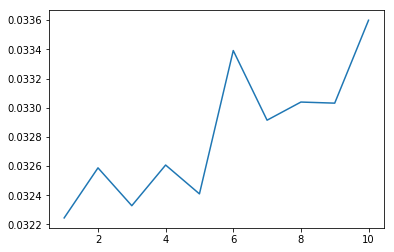

In [11]:
plt.plot(estimation_ranks, errors)
plt.show()

Error for both changing rank( 1 to M) and max_iter(5000-20000).

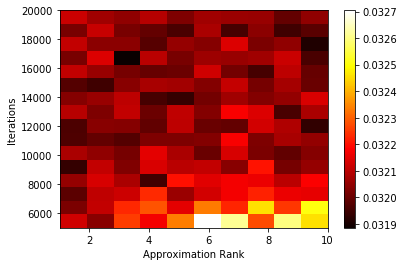

In [6]:
ITER_M = np.linspace(5000,20000,16)
RANK_M = np.arange(1,M+1)
EE1 = np.zeros((len(ITER_M),len(RANK_M)))
for i,max_iter in enumerate(ITER_M):
    for j,estimation_rank in enumerate(RANK_M):
        W, H = sgd(Y, mask, estimation_rank, MAX_ITER = int(round(max_iter)))
        # Error is - log likelyhood
        EE1[i,j] = -np.sum((YM*np.log(sigmoid(np.dot(W,H))) +  (mask-YM)*np.log(1 - sigmoid(np.dot(W,H)))))/num_of_obs
plt.figure(2)
plt.imshow(EE1, cmap='hot', interpolation='nearest', origin='lower',
           extent=[min(RANK_M),max(RANK_M),min(ITER_M),max(ITER_M)], aspect='auto')
plt.ylabel('Iterations')
plt.xlabel('Approximation Rank')
plt.colorbar()
plt.show()

Analysis of the effect of varying mask_scale. (from 0.1 to 1.0 increasing by 0.1)

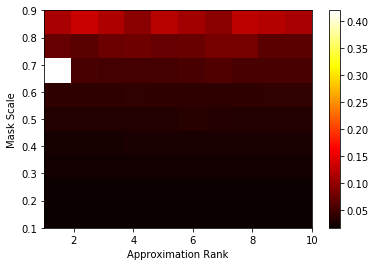

In [7]:
MASK_M = np.linspace(0.1,1.0,9,endpoint=False)
EE2 = np.zeros((len(MASK_M),len(RANK_M)))
for i,mask_scale in enumerate(MASK_M):
    for j,estimation_rank in enumerate(RANK_M):
        mask = generate_mask(M, mask_scale)
        num_of_obs = np.sum(mask==1)
        Y = original_matrix.copy()
        Y[mask==False] = np.nan
        YM = Y.copy()
        YM[mask==False] = 0
        W, H = sgd(Y, mask, estimation_rank)
        # Error is - log likelyhood
        EE2[i,j] = -np.sum((YM*np.log(sigmoid(np.dot(W,H))) +  (mask-YM)*np.log(1 - sigmoid(np.dot(W,H)))))/num_of_obs
plt.figure(3)
plt.imshow(EE2, cmap='hot', interpolation='nearest', origin='lower',
           extent=[min(RANK_M),max(RANK_M),min(MASK_M),max(MASK_M)], aspect='auto')
plt.ylabel('Mask Scale')
plt.xlabel('Approximation Rank')
plt.colorbar()
plt.show()

Original data, masked data, prediction and error

0 -1.1588542513156586
500 -0.022891392260716764
1000 -0.022172431572906756
1500 -0.02142335624575443
2000 -0.020894169814051355
2500 -0.02058346291497539
3000 -0.020406827612464977


Text(0.5,1,'Error')

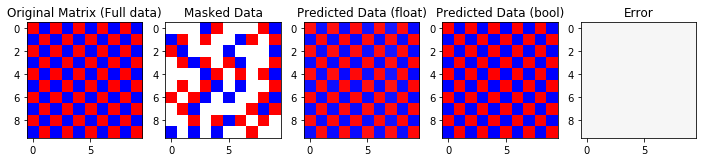

In [8]:
mask = generate_mask(M, 0.5)
num_of_obs = np.sum(mask==1)
Y = original_matrix.copy()
Y[mask==False] = np.nan
W, H = sgd(original_matrix=Y, mask=mask, estimation_rank=10, MAX_ITER=3001, PRINT_PERIOD=500, batch_scale=1)
thr = 0.5
fig=plt.figure(figsize=(12, 6))
plt.subplot(1,5,1)
plt.imshow(original_matrix, cmap='bwr', vmin=0, vmax=1)
plt.title('Original Matrix (Full data)')
plt.subplot(1,5,2)
plt.imshow(Y, cmap='bwr', vmin=0, vmax=1)
plt.title('Masked Data')
plt.subplot(1,5,3)
Y_pred = sigmoid(W.dot(H))
plt.imshow(Y_pred, cmap='bwr', vmin=0, vmax=1)
plt.title('Predicted Data (float)')
ax = plt.subplot(1,5,4)
Y_rec = Y_pred > thr
plt.imshow(Y_rec, cmap='bwr', vmin=0, vmax=1)
plt.title('Predicted Data (bool)')
ax2 = plt.subplot(1,5,5)
plt.imshow(original_matrix - Y_rec, cmap='PiYG', vmin=-1, vmax=1)
plt.title('Error')



## With PyTorch

Again, you can use the batch size parameter to obtain all types of gradient descents.

In [12]:
import torch as tr
import torch.autograd
from torch.autograd import Variable

def pytorch_sga(original_matrix, mask, estimation_rank, MAX_ITER=3000, PRINT_PERIOD=None, batch_scale=0.4, eta=0.0045, nu=0.1):  
    M = original_matrix.shape[0]
    N = original_matrix.shape[1]
    num_of_obs = np.sum(mask==1)
    num_of_obs = num_of_obs.astype(float)

    batch_size = round(batch_scale*N)
    if batch_size == 0: batch_size = 1
    
    W = Variable( tr.from_numpy(np.random.randn(M,estimation_rank)), requires_grad=True)
    H = Variable( tr.from_numpy(np.random.randn(estimation_rank,N)), requires_grad=True)
    
    YM = original_matrix.copy()
    YM[mask==False] = 0
    YM = Variable ( torch.from_numpy(YM))
    mask = Variable(torch.from_numpy(mask))
    
    for epoch in range(MAX_ITER):
        idx = np.random.choice(N, batch_size, replace=False).tolist()
        mask_sample = mask[:,idx]
        H_sample = Variable( tr.from_numpy(H[:,idx].data.numpy()), requires_grad=True)
        
        YM_sample = YM[:,idx]
        
        sig = ( tr.sigmoid(tr.matmul(W, H_sample)))
        LL_sample = tr.sum( (YM_sample*tr.log(sig)) + (mask_sample-YM_sample)*tr.log(1-sig))-nu*tr.sum(H_sample**2) / 2.0 - nu*tr.sum(W**2)
        
        LL_sample.backward()
        
        W.data.add_(eta * W.grad.data)
        H[:,idx].data.add_(eta * H_sample.grad.data)
        H_sample.grad.zero_()
        W.grad.zero_()
        
        if PRINT_PERIOD is not None and epoch % PRINT_PERIOD == 0:
            sig = ( tr.sigmoid(tr.matmul(W, H)))
            LL = -tr.sum( (YM*tr.log(sig) + (mask-YM)*tr.log(1 - sig)) ) / num_of_obs
            # - nu*np.sum(H**2)/2.0 - nu*np.sum(W**2)/2.0
            print(epoch, LL.data.numpy())
            
    return W.data.numpy(), H.data.numpy()

mask = generate_mask(M, 0.5)
num_of_obs = np.sum(mask==1)
Y = original_matrix.copy()
Y[mask==False] = np.nan

errors = [] # store the error to this list.
YM = Y.copy()
YM[mask==False] = 0
estimation_ranks = range(1, M+1)
for estimation_rank in estimation_ranks:
    W, H = pytorch_sga(Y, mask, estimation_rank)
    errors.append( -np.sum((YM*np.log(sigmoid(np.dot(W,H))) +  (mask-YM)*np.log(1 - sigmoid(np.dot(W,H)))))/num_of_obs )
    

Plot error vs estimation_rank

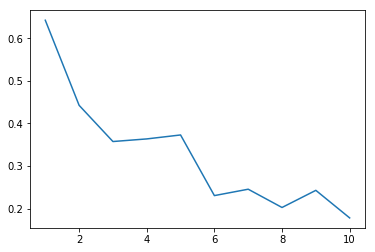

In [13]:
plt.figure(4)
plt.plot(estimation_ranks, errors)
plt.show()

Error for both changing rank( 1 to M) and max_iter(5000-20000).

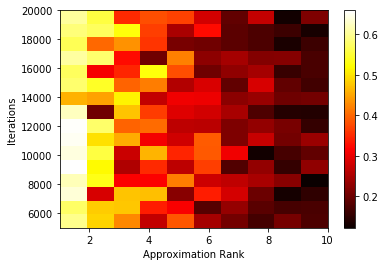

In [11]:
ITER_M = np.linspace(5000,20000,16)
RANK_M = np.arange(1,M+1)
EE1 = np.zeros((len(ITER_M),len(RANK_M)))
for i,max_iter in enumerate(ITER_M):
    for j,estimation_rank in enumerate(RANK_M):
        W, H = pytorch_sga(Y, mask, estimation_rank, MAX_ITER = int(round(max_iter)))
        EE1[i,j] = -np.sum((YM*np.log(sigmoid(np.dot(W,H))) +  (mask-YM)*np.log(1 - sigmoid(np.dot(W,H)))))/num_of_obs
plt.figure(5)
plt.imshow(EE1, cmap='hot', interpolation='nearest', origin='lower',
           extent=[min(RANK_M),max(RANK_M),min(ITER_M),max(ITER_M)], aspect='auto')
plt.ylabel('Iterations')
plt.xlabel('Approximation Rank')
plt.colorbar()
plt.show()

Analysis of the effect of varying mask_scale. (from 0.1 to 1.0 increasing by 0.1)

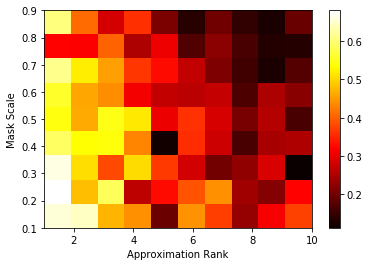

In [12]:
MASK_M = np.linspace(0.1,1.0,9,endpoint=False)
EE2 = np.zeros((len(MASK_M),len(RANK_M)))
for i,mask_scale in enumerate(MASK_M):
    for j,estimation_rank in enumerate(RANK_M):
        mask = generate_mask(M, mask_scale)
        num_of_obs = np.sum(mask==1)
        Y = original_matrix.copy()
        Y[mask==False] = np.nan
        YM = Y.copy()
        YM[mask==False] = 0
        W, H = pytorch_sga(Y, mask, estimation_rank)
        EE2[i,j] = -np.sum((YM*np.log(sigmoid(np.dot(W,H))) +  (mask-YM)*np.log(1 - sigmoid(np.dot(W,H)))))/num_of_obs
plt.figure(6)
plt.imshow(EE2, cmap='hot', interpolation='nearest', origin='lower',
           extent=[min(RANK_M),max(RANK_M),min(MASK_M),max(MASK_M)], aspect='auto')
plt.ylabel('Mask Scale')
plt.xlabel('Approximation Rank')
plt.colorbar()
plt.show()

 Original data, masked data, prediction and error

0 [1.49888465]
500 [0.11548936]
1000 [0.09539203]
1500 [0.09122939]
2000 [0.08990944]
2500 [0.08939241]


Text(0.5,1,'Error')

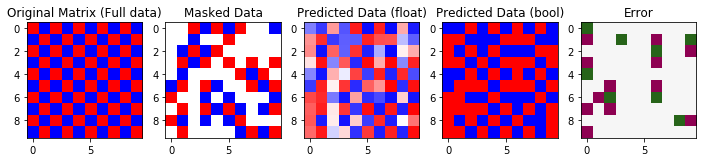

In [56]:
mask = generate_mask(M, 0.5)
num_of_obs = np.sum(mask==1)
Y = original_matrix.copy()
Y[mask==False] = np.nan
W, H = pytorch_sga(original_matrix=Y, mask=mask, estimation_rank=10, MAX_ITER=3000, PRINT_PERIOD=500, batch_scale=1)
thr = 0.50
fig=plt.figure(figsize=(12, 6))
plt.subplot(1,5,1)
plt.imshow(original_matrix, cmap='bwr', vmin=0, vmax=1)
plt.title('Original Matrix (Full data)')
plt.subplot(1,5,2)
plt.imshow(Y, cmap='bwr', vmin=0, vmax=1)
plt.title('Masked Data')
plt.subplot(1,5,3)
Y_pred = sigmoid(W.dot(H))
plt.imshow(Y_pred, cmap='bwr', vmin=0, vmax=1)
plt.title('Predicted Data (float)')
ax = plt.subplot(1,5,4)
Y_rec = Y_pred > thr
plt.imshow(Y_rec, cmap='bwr', vmin=0, vmax=1)
plt.title('Predicted Data (bool)')
ax2 = plt.subplot(1,5,5)
plt.imshow(original_matrix - Y_rec, cmap='PiYG', vmin=-1, vmax=1)
plt.title('Error')